#Analyising the Utah Avalanche Statistics

By Dhruv Rachakonda

<p>University of Utah</p>


#Introduction

The purpose of this analysis is to determine if there is a relationship between a trigger of an avalanche versus the area of an avalanche. Id est, are cetain types of avalanches more likely to increase the area of an avalanche. As such, I have chosen the following question: **Is there a relationship between certain types of avalanche triggers and the area of the avalanches caused by that trigger?** In other words, is a certain type of avalanche trigger on average more likely to cause a larger area?

Let us start off by importing the neccesary libraries to conduct this analysis

In [ ]:
import requests
# BeautifulSoup is a module inside the "bs4" library, we only import the BeautifulSoup module
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import numpy as np

# Reading in Data
We will be scraping the Utah Avalanche Center website.

We can star off by putting all of the raw HTML data into a variable and begin processing it. We need to specify certain parameters or else the protection software of the website will reject our requests. The requests library will gather all of the HTML data and put it into a variable for us.

Beautiful soup in this case just helps us with formatting the data such as finding data within tags.

In [ ]:
headers = {
  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"
}

baseurl = "https://utahavalanchecenter.org/avalanches"

req = requests.get(baseurl, headers=headers)

avalanche_soup = BeautifulSoup(req.text)

print(avalanche_soup)

A pattern that I am seeing here is that each row is seperated by a tr tag. We can place all the tr values in an array. We have 51 rows here. For reference, this is what the last row looks like. We can use the find all function to gather all tags that have the tr tag and place it into an array list. All the content between a given tr tag is a single index. We are using the beautiful soup's find all function to store all tags with tr as an array index.


In [ ]:
avalanche_groups = avalanche_soup.find_all('tr')
print(len(avalanche_groups))
avalanche_groups[-1]


51


<tr>
<td class="views-field views-field-field-occurrence-date">
<span class="date-display-single">2/4/2022</span> </td>
<td class="views-field views-field-title">
<a href="/avalanche/66179">Avalanche: Brighton Hill</a> </td>
<td class="views-field views-field-field-region-forecaster nowrap">
      Salt Lake    </td>
<td class="views-field views-field-field-trigger">
      Skier    </td>
<td class="views-field views-field-field-depth views-align-right">
      4"    </td>
<td class="views-field views-field-field-width views-align-right">
      5'    </td>
</tr>

We can also notice that in each row, every column value is seperated by a td tag. Let us print out the contants of the td tag of the first row. We're using index 1 here, since index 0 is just the title. The strip function just removes white space around the edges of the string.

In [ ]:
for group in avalanche_groups[1].find_all("td"):
   print(group.text.strip())

2/28/2022
Avalanche: Porter Fork
Salt Lake

14"
60'


Let us now try writing a parser for one page. I'm initializing a data structure here which is just a simple array.

Through each iteration on each row, I store the contents of a row page in a JSON style payload, and then append that payload onto the avalanches_ds data structure.

I'm also replacing any values that say "unknown" or any blank values with NaN. This will make the clean up process later on easier

In [ ]:
avalanches_ds = []


for x in range(1, len(avalanche_groups)):

    #.find function to find certain aspects in a row such as date based on tag, and stores them into variable
    date = avalanche_groups[x].find('td',{'class':"views-field views-field-field-occurrence-date"})
    title = avalanche_groups[x].find('td',{'class':"views-field views-field-title"})
    region = avalanche_groups[x].find('td',{'class':"views-field views-field-field-region-forecaster nowrap"})
    trigger = avalanche_groups[x].find('td',{'class':"views-field views-field-field-trigger"})
    depth = avalanche_groups[x].find('td',{'class':"views-field views-field-field-depth views-align-right"})
    width = avalanche_groups[x].find('td',{'class':  "views-field views-field-field-width views-align-right"})


    #converting the html text to type string and removing all the white space around the edges of it
    date = date.text.strip()
    title = title.text.strip()
    region = region.text.strip()
    trigger = trigger.text.strip()
    depth = depth.text.strip()
    width = width.text.strip()


    #blank/missing value handling
    if(trigger == ""):
      trigger = np.nan


    if(trigger == "Unknown"):
      trigger = np.nan

    if(depth == ""):
      depth = np.nan

    if(width == ""):
      width = np.nan

    #payload for a single row
    avalanche_payload = {'Date': date,
                                 'Name':title,
                                 'Region':region,
                                 'Trigger':trigger,
                                 'Depth':depth,
                                 'Width': width
                                      }

    #push payload to the data structure initalized earlier
    avalanches_ds.append(avalanche_payload)

#creating pandas data frame and seeing its tail to see if our parser worked
avalanches_df = pd.DataFrame(avalanches_ds)
avalanches_df.head(5)

,Date,Name,Region,Trigger,Depth,Width
0,2/28/2022,Avalanche: Porter Fork,Salt Lake,NaN,"14""",60'
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,NaN,NaN
2,2/27/2022,Avalanche: Home Run,Salt Lake,Natural,NaN,NaN
3,2/27/2022,Avalanche: Gold Basin,Moab,Skier,2',25'
4,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,NaN,NaN


We have enough to write our final parser now. I'm initializing a data structure here which is just a simple array. I'm looping through all 123 potential pages (I did that just by taking the last number of the url, and kept experimenting with numbers until I found the last page. The last number on the url represents the current page we're on.

Within the page for loop, there is another for loop which loops through each row on the current page. Like done above, we are placing the contents of the current row into a JSON style payload, and placing it into the overall data strucutre after each iteration of each row.

This is done for all 123 pages.

I'm also adding a sleep function through each iteration so we don't destroy the website's servers, and will scrape in moderation.

**Warning:** This parser takes a very long time to run. Exercise consideration when executing anything.

In [ ]:
avalanches_ds = []

#looping through 123 potential pages
for page in range (0, 122):

  #sleep function so we can avoid overloading of the website's servers
  sleep(1)

  #header code to bypass protection clearances for website
  headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"
  }



  #to determine which page we are going to be scraping
  baseurl = "https://utahavalanchecenter.org/avalanches?page=" + str(page)

  #there is a unique url for the first page
  if(page == 0):
      baseurl = "https://utahavalanchecenter.org/avalanches"



  req = requests.get(baseurl, headers=headers)

  avalanche_soup = BeautifulSoup(req.text)

  #now we are looping through each and every row on the current page
  for x in range(1, len(avalanche_groups)):


    date = avalanche_groups[x].find('td',{'class':"views-field views-field-field-occurrence-date"})
    title = avalanche_groups[x].find('td',{'class':"views-field views-field-title"})
    region = avalanche_groups[x].find('td',{'class':"views-field views-field-field-region-forecaster nowrap"})
    trigger = avalanche_groups[x].find('td',{'class':"views-field views-field-field-trigger"})
    depth = avalanche_groups[x].find('td',{'class':"views-field views-field-field-depth views-align-right"})
    width = avalanche_groups[x].find('td',{'class':  "views-field views-field-field-width views-align-right"})

    date = date.text.strip()
    title = title.text.strip()
    region = region.text.strip()
    trigger = trigger.text.strip()
    depth = depth.text.strip()
    width = width.text.strip()

    #handling missing values - i dont really care about missing dates or titles here since we arent using that for our final conclusion
    if(trigger == "Unknown"):
      trigger = np.nan

    if(trigger == ""):
      trigger = np.nan


    if(depth == ""):
      depth = np.nan

    if(width == ""):
      width = np.nan

    #payload for current row
    avalanche_payload = {'Date': date,
                                 'Name':title,
                                 'Region':region,
                                 'Trigger':trigger,
                                 'Depth':depth,
                                 'Width': width
                                      }

    #and we shall append the current row payload to the overall data structure
    avalanches_ds.append(avalanche_payload)







In [ ]:
avalanches_df = pd.DataFrame(avalanches_ds)
avalanches_df.head(10)

,Date,Name,Region,Trigger,Depth,Width
0,2/28/2022,Avalanche: Porter Fork,Salt Lake,NaN,"14""",60'
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,NaN,NaN
2,2/27/2022,Avalanche: Home Run,Salt Lake,Natural,NaN,NaN
3,2/27/2022,Avalanche: Gold Basin,Moab,Skier,2',25'
4,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,NaN,NaN
5,2/26/2022,Avalanche: Spire,Salt Lake,Skier,"18""",50'
6,2/26/2022,Avalanche: Mill A,Salt Lake,Skier,"12""",35'
7,2/26/2022,Avalanche: Sundance,Provo,Skier,"12""",15'
8,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,NaN,NaN
9,2/26/2022,Avalanche: Highline,Salt Lake,Natural,NaN,20'


In [ ]:
avalanches_df.tail(10)

,Date,Name,Region,Trigger,Depth,Width
6090,2/20/2022,Avalanche: Big Horseshoe,Skyline,Natural,"6""",40'
6091,2/20/2022,Avalanche: Wolf Creek Bowl,Uintas,Skier,"4""",30'
6092,2/19/2022,Avalanche: Mill B South,Salt Lake,Snowboarder,"12""",30'
6093,2/18/2022,Avalanche: Red Baldy,Salt Lake,Skier,"12""",30'
6094,2/17/2022,Avalanche: Superior,Salt Lake,Skier,"6""",20'
6095,2/17/2022,Avalanche: BBQ Bowl,Skyline,Natural,"6""",60'
6096,2/13/2022,Avalanche: Belicosity Bowl,Logan,Natural,NaN,40'
6097,2/12/2022,Avalanche: Santaquin Peak,Provo,Skier,"10""",5'
6098,2/12/2022,Avalanche: Salt Lake,Salt Lake,Skier,NaN,NaN
6099,2/4/2022,Avalanche: Brighton Hill,Salt Lake,Skier,"4""",5'


Everything looks perfect. We can now begin our exploratory data analysis

#Exploratory Data Analysis

We have read in our data already through the above web scraping process. Let us move onto the next phase.


#Checking packaging

Let us see how may rows of data we are working with, as well as how many rows there are for each avalanche incident.

In [ ]:
avalanches_df.shape

(6100, 6)

There are current 6100 different avalanche incidents that we are working with here, as well as 6 different columns describing each incident. However, the number of avalanche incidents is going to decrease, as there are many NaN values we are going to have to deal with. However, in this case, we only care about depth and width, as well as trigger.

#Examining Top and Bottom of Data

In [ ]:
avalanches_df.head()

,Date,Name,Region,Trigger,Depth,Width
0,2/28/2022,Avalanche: Porter Fork,Salt Lake,NaN,"14""",60'
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,NaN,NaN
2,2/27/2022,Avalanche: Home Run,Salt Lake,Natural,NaN,NaN
3,2/27/2022,Avalanche: Gold Basin,Moab,Skier,2',25'
4,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,NaN,NaN


In [ ]:
avalanches_df.tail()

,Date,Name,Region,Trigger,Depth,Width
6095,2/17/2022,Avalanche: BBQ Bowl,Skyline,Natural,"6""",60'
6096,2/13/2022,Avalanche: Belicosity Bowl,Logan,Natural,NaN,40'
6097,2/12/2022,Avalanche: Santaquin Peak,Provo,Skier,"10""",5'
6098,2/12/2022,Avalanche: Salt Lake,Salt Lake,Skier,NaN,NaN
6099,2/4/2022,Avalanche: Brighton Hill,Salt Lake,Skier,"4""",5'


Not much can be concluded from examining the head and tail of our data in terms of the relationship between area of avalanche and the trigger.However, the data appears to be appropriately formatted in both the head and tail. We can also see the NaN values we have to deal with during the clean up later on.

#Checking Ns
Let us see how many different triggers of avalanches we are working with here.


In [ ]:
avalanches_df['Trigger'].value_counts()

Skier          2318
Natural        2074
Snowmobiler     976
Snowboarder     488
Name: Trigger, dtype: int64

It looks like we are working with 4 different types of triggers.

This is the only N that we can check for at the moment.

The area of a given avalanche can be calculated for the purposes of this analysis by multiplying the depth times the width of the given avalanche.

# Validation with External Data Source

Referring to the earlier part where we were checking Ns, it looks like the most common reason for an avalanche non-natural reasons, such as skiers and snowboarders.

According to the Sierra Avalanche Center: https://www.sierraavalanchecenter.org/FAQ , "In 90 percent of all avalanche accidents, the avalanche is triggered by the victim, or someone in the victim's party."

In other words, most avalanches are caused by the victims of the avalanche. The data matches this, showing that most of the avalanches in our data are man-made triggers. We can conclude that the data we have extracted is accurate.

#Formatting/Cleaning Data - Deletion

We can recall that our data had a lot of missing (NaN) values. Ideally, using deletion is the best way since adding values that never existed may affect our conclusion. The data in this case is missing not at random (MNAR). It is likely that the reported avalanche could not be measured at the time, or it was not noticed what caused it. We should delete these values, as using the average area would potentially be more problamatic for our conclusion, since our conclusion is based entirely on the average area of our values. It would also not change anything, as adding the average to any group of values will not change the area

I still intend to experiment with both deletion and imputing in this analysis to see if either or effects the conclusion.

Our initial step here is to reformat the values. We will start off by delete all NaN values in the trigger using the Pandas dropna() function.

In [ ]:
dropped_av = avalanches_df.dropna(subset = ['Trigger'])
print("There are {0:,} rows of data after dropping, compared to {1:,} before.".format(len(dropped_av),
                                                                                     len(avalanches_df)))


There are 5,856 rows of data after dropping, compared to 6,100 before.


This is not too bad of a number. We only lost 2% of the data we once had. Let's drop the missing depth and width values now

In [ ]:
dropped_av_2 = dropped_av.dropna(subset = ['Depth'])
print("There are {0:,} rows of data after dropping, compared to {1:,} before.".format(len(dropped_av_2),
                                                                                     len(dropped_av)))


There are 4,880 rows of data after dropping, compared to 5,856 before.


Once again not too bad. The loss percentage here is 14%. Let's finish off by dropping the missing width values now

In [ ]:
dropped_av_3 = dropped_av_2.dropna(subset = ['Width'])
print("There are {0:,} rows of data after dropping, compared to {1:,} before.".format(len(dropped_av_3),
                                                                                     len(dropped_av_2)))

There are 4,636 rows of data after dropping, compared to 4,880 before.


Once we complete the deletion process, our data size has dropped from 6100 to 4636. This is a loss percentage of 21%, which isn't too bad. Let's examine the head and tail of our data one more time. We'll give our data structure a nicer name to start.

In [ ]:
dropped_av = dropped_av_3
dropped_av.head(10)

,Date,Name,Region,Trigger,Depth,Width
3,2/27/2022,Avalanche: Gold Basin,Moab,Skier,2',25'
5,2/26/2022,Avalanche: Spire,Salt Lake,Skier,"18""",50'
6,2/26/2022,Avalanche: Mill A,Salt Lake,Skier,"12""",35'
7,2/26/2022,Avalanche: Sundance,Provo,Skier,"12""",15'
11,2/26/2022,Avalanche: Black Mountain,Skyline,Snowmobiler,2.5',500'
12,2/26/2022,"Avalanche: Grandfather Cornice, Nose",Logan,Snowmobiler,"8""",60'
14,2/25/2022,Avalanche: Ephraim Canyon,Skyline,Snowmobiler,2.5',700'
15,2/25/2022,Avalanche: Chalk Creek,Uintas,Snowboarder,"10""",100'
16,2/25/2022,Avalanche: Skyline,Skyline,Snowmobiler,"7""",800'
17,2/25/2022,Avalanche: Neffs,Salt Lake,Skier,2',100'


In [ ]:
dropped_av.tail(10)

,Date,Name,Region,Trigger,Depth,Width
6088,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'
6089,2/22/2022,Avalanche: Davis Canyon,Provo,Natural,"18""",400'
6090,2/20/2022,Avalanche: Big Horseshoe,Skyline,Natural,"6""",40'
6091,2/20/2022,Avalanche: Wolf Creek Bowl,Uintas,Skier,"4""",30'
6092,2/19/2022,Avalanche: Mill B South,Salt Lake,Snowboarder,"12""",30'
6093,2/18/2022,Avalanche: Red Baldy,Salt Lake,Skier,"12""",30'
6094,2/17/2022,Avalanche: Superior,Salt Lake,Skier,"6""",20'
6095,2/17/2022,Avalanche: BBQ Bowl,Skyline,Natural,"6""",60'
6097,2/12/2022,Avalanche: Santaquin Peak,Provo,Skier,"10""",5'
6099,2/4/2022,Avalanche: Brighton Hill,Salt Lake,Skier,"4""",5'


I'm not seeing anymore missing values. This looks good. Our next step is to reformat the numbers for depth and width. We need to create a new column called area. Normally, we could just remove the inches or foot symbol, however we won't know what unit of measurement we're multiplying by, if it is feet or inches. We can just convert all values here to inches by either leaving values with the inches symbol next to them alone, or by diving by 12 if it has a foot symbol.

So if the measurement is in feet, we'll convert it to inches by diving the value by 12 and remove the symbol, as well as converting it to an int. Otherwise if it is inches, we are removing the inches symbol and converting it to and int.

I looped through the depth and width columns and for each index, checked what the last value was. I then removed the symbol, converted the value to float,  and converted it to inches by dividing by 12 if it was a foot value.

In [ ]:
for index in range(0, (len(dropped_av))):
  dropped_av['Depth'].iloc[index] = dropped_av['Depth'].iloc[index].replace(',', "") #removing any annoying commas that might interfere with our cleaning

  if dropped_av['Depth'].iloc[index][-1] == '"': #checking last charcter
    dropped_av['Depth'].iloc[index] = dropped_av['Depth'].iloc[index].replace('"', "")
    dropped_av['Depth'].iloc[index] = float(dropped_av['Depth'].iloc[index]) #convert it to float when cleaned
  elif dropped_av['Depth'].iloc[index][-1] == "'":
    dropped_av['Depth'].iloc[index] = dropped_av['Depth'].iloc[index].replace("'", "")
    dropped_av['Depth'].iloc[index] = float(dropped_av['Depth'].iloc[index])
    dropped_av['Depth'].iloc[index] = dropped_av['Depth'].iloc[index] * 12

#I did two seperate loops for readability

for index in range(0, (len(dropped_av))):
  dropped_av['Width'].iloc[index] = dropped_av['Width'].iloc[index].replace(',', "") #removing any annoying commas that might interfere with our cleaning

  if dropped_av['Width'].iloc[index][-1] == '"': #checking last charcter
    dropped_av['Width'].iloc[index] = dropped_av['Width'].iloc[index].replace(',', "") #removing any annoying commas that might interfere with our cleaning
    dropped_av['Width'].iloc[index] = dropped_av['Width'].iloc[index].replace('"', "") #convert it to float when cleaned
    dropped_av['Width'].iloc[index] = float(dropped_av['Width'].iloc[index])
  elif dropped_av['Width'].iloc[index][-1] == "'":
    dropped_av['Width'].iloc[index] = dropped_av['Width'].iloc[index].replace("'", "")
    dropped_av['Width'].iloc[index] = float(dropped_av['Width'].iloc[index]) #convert it to float first
    dropped_av['Width'].iloc[index] = dropped_av['Width'].iloc[index] * 12 #then convert to inches





/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Let's check the head and tail to see how our data looks

In [ ]:
dropped_av.head()

,Date,Name,Region,Trigger,Depth,Width
3,2/27/2022,Avalanche: Gold Basin,Moab,Skier,24.0,300.0
5,2/26/2022,Avalanche: Spire,Salt Lake,Skier,18.0,600.0
6,2/26/2022,Avalanche: Mill A,Salt Lake,Skier,12.0,420.0
7,2/26/2022,Avalanche: Sundance,Provo,Skier,12.0,180.0
11,2/26/2022,Avalanche: Black Mountain,Skyline,Snowmobiler,30.0,6000.0


In [ ]:
dropped_av.tail()

,Date,Name,Region,Trigger,Depth,Width
6093,2/18/2022,Avalanche: Red Baldy,Salt Lake,Skier,12.0,360.0
6094,2/17/2022,Avalanche: Superior,Salt Lake,Skier,6.0,240.0
6095,2/17/2022,Avalanche: BBQ Bowl,Skyline,Natural,6.0,720.0
6097,2/12/2022,Avalanche: Santaquin Peak,Provo,Skier,10.0,60.0
6099,2/4/2022,Avalanche: Brighton Hill,Salt Lake,Skier,4.0,60.0


We have now converted all values in the data to inches. To finish, let us also create a new column called "area", which is just the depth times the width.

In [ ]:
dropped_av["Area"] = dropped_av["Depth"] * dropped_av["Width"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dropped_av.head()

,Date,Name,Region,Trigger,Depth,Width,Area
3,2/27/2022,Avalanche: Gold Basin,Moab,Skier,24.0,300.0,7200.0
5,2/26/2022,Avalanche: Spire,Salt Lake,Skier,18.0,600.0,10800.0
6,2/26/2022,Avalanche: Mill A,Salt Lake,Skier,12.0,420.0,5040.0
7,2/26/2022,Avalanche: Sundance,Provo,Skier,12.0,180.0,2160.0
11,2/26/2022,Avalanche: Black Mountain,Skyline,Snowmobiler,30.0,6000.0,180000.0


In [ ]:
dropped_av.tail()

,Date,Name,Region,Trigger,Depth,Width,Area
6093,2/18/2022,Avalanche: Red Baldy,Salt Lake,Skier,12.0,360.0,4320.0
6094,2/17/2022,Avalanche: Superior,Salt Lake,Skier,6.0,240.0,1440.0
6095,2/17/2022,Avalanche: BBQ Bowl,Skyline,Natural,6.0,720.0,4320.0
6097,2/12/2022,Avalanche: Santaquin Peak,Provo,Skier,10.0,60.0,600.0
6099,2/4/2022,Avalanche: Brighton Hill,Salt Lake,Skier,4.0,60.0,240.0


Our area column looks perfect. We can now move onto the next method of cleaning: imputing

#Formatting/Cleaning Data - Imputation


Using our deleted data set, we can calculate the mean depth and width for each type of trigger and impute it into the NaN value.

Recall that we are only working with 4 types of triggers

In [ ]:
avalanches_df['Trigger'].value_counts()

Skier          2318
Natural        2074
Snowmobiler     976
Snowboarder     488
Name: Trigger, dtype: int64

We can do some handling to calculate the mean values of each type of trigger. We will then add it into a data structure, and calculate the average of it.

In [ ]:
natural_depth = []
skier_depth = []
snowmobiler_depth = []
snowboarder_depth = []

for index in range(0, (len(dropped_av))):
  if dropped_av['Trigger'].iloc[index] == "Skier":
    skier_depth.append(dropped_av['Depth'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Natural":
    natural_depth.append(dropped_av['Depth'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Snowmobiler":
    snowmobiler_depth.append(dropped_av['Depth'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Snowboarder":
    snowboarder_depth.append(dropped_av['Depth'].iloc[index])


natural_width = []
skier_width = []
snowmobiler_width = []
snowboarder_width = []

for index in range(0, (len(dropped_av))):
  if dropped_av['Trigger'].iloc[index] == "Skier":
    skier_width.append(dropped_av['Width'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Natural":
    natural_width.append(dropped_av['Width'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Snowmobiler":
    snowmobiler_width.append(dropped_av['Width'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Snowboarder":
    snowboarder_width.append(dropped_av['Width'].iloc[index])


In [ ]:
natural_depth = pd.DataFrame(natural_depth)
skier_depth = pd.DataFrame(skier_depth)
snowmobiler_depth = pd.DataFrame(snowmobiler_depth)
snowboarder_depth = pd.DataFrame(snowboarder_depth)
natural_width = pd.DataFrame(natural_width)
skier_width = pd.DataFrame(skier_width)
snowmobiler_width = pd.DataFrame(snowmobiler_width)
snowboarder_width = pd.DataFrame(snowmobiler_width)

Let us see what the mean looks like on all of these

In [ ]:
print((natural_depth.mean()))
print(skier_depth.mean())
print(snowmobiler_depth.mean())
print(snowboarder_depth.mean())
print(natural_width.mean())
print(skier_width.mean())
print(snowmobiler_width.mean())
print(snowboarder_width.mean())

0    19.75
dtype: float64
0    12.388889
dtype: float64
0    18.875
dtype: float64
0    12.5
dtype: float64
0    4800.0
dtype: float64
0    663.333333
dtype: float64
0    4432.5
dtype: float64
0    4432.5
dtype: float64


The values appear to be reasonable, so we can go forward and use these mean values for our impution process. Let us first start with our impution before we move onto cleaning up the entire row. We can start by ordering the data frame based on trigger. The first chunk of the data will be only a type of trigger, and so on.

Unfortunately, I cannot think of a way to replace the missing trigger NaNs. These values are likely missing not at random (MNAR) and there is no way to generate a value for them that is not random. I would prefer to stay away from randomly generating one of four possible triggers, as this is not a methodical way to handle missing triggers.

In [ ]:
replaced_av = pd.DataFrame(avalanches_df)
replaced_av = replaced_av.dropna(subset = ['Trigger'])
replaced_av = replaced_av.sort_values(by = ['Trigger'])


last_natural_index = 0

for index in range(0, len(replaced_av)):
  if replaced_av["Trigger"].iloc[index] == "Skier":
    last_natural_index = index-1
    break


#now we know that all values from 0 to last_natural_index are guaranteed to be natural trigger

last_skier_index = 0

for index in range(0, len(replaced_av)):
  if replaced_av["Trigger"].iloc[index] == "Snowboarder":
    last_skier_index = index-1
    break

#now we know that all values from last_natural_index + 1 to last_skier_index are guaranteed to be ski trigger

last_board_index = 0

for index in range(0, len(replaced_av)):
  if replaced_av["Trigger"].iloc[index] == "Snowmobiler":
    last_board_index = index-1
    break

#now we know that all values from last_skier_index + 1 to last_board_index are guaranteed to be ski snowboarder

#we also know that all values from last_board_index to len(replaced_av) are guaranteed to be snowmobiler


We can test this to make sure that we have our indexes correct

In [ ]:
print(replaced_av["Trigger"].iloc[last_natural_index])
#should transition onto next trigger here
print(replaced_av["Trigger"].iloc[last_natural_index+1])

print(replaced_av["Trigger"].iloc[last_skier_index])
#should transition onto next trigger here
print(replaced_av["Trigger"].iloc[last_skier_index+1])


print(replaced_av["Trigger"].iloc[last_board_index])
#should transition onto next trigger here
print(replaced_av["Trigger"].iloc[last_board_index+1])



Natural
Skier
Skier
Snowboarder
Snowboarder
Snowmobiler


We now know the ranges of the ordered list. We can call the fillna function by creating four seperate data structures and callig fillna() on them.

In [ ]:
natural_values = replaced_av[:last_natural_index]
skier_values = replaced_av[last_natural_index + 1 : last_skier_index]
board_values = replaced_av[last_skier_index + 1 : last_board_index]
mobile_values = replaced_av[last_board_index + 1 : ]

natural_values.head()

,Date,Name,Region,Trigger,Depth,Width
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,NaN,NaN
1954,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,NaN,NaN
4410,2/26/2022,Avalanche: Bartholomew Canyon,Provo,Natural,"15""",NaN
1958,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,NaN,NaN
1959,2/26/2022,Avalanche: Highline,Salt Lake,Natural,NaN,20'


We can now call a fillna() on each of these respective data structures using the respective mean for each of these values.




In [ ]:
natural_values["Depth"] = natural_values["Depth"].fillna(float(natural_depth.mean()))
natural_values["Width"] = natural_values["Width"].fillna(float(natural_width.mean()))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


And check the head and tail of the values. We'll do this for all 4 dataframes.

In [ ]:
natural_values.head()

,Date,Name,Region,Trigger,Depth,Width
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,19.75,4800.0
1954,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,19.75,4800.0
4410,2/26/2022,Avalanche: Bartholomew Canyon,Provo,Natural,"15""",4800.0
1958,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,19.75,4800.0
1959,2/26/2022,Avalanche: Highline,Salt Lake,Natural,19.75,20'


In [ ]:
natural_values.tail()

,Date,Name,Region,Trigger,Depth,Width
939,2/22/2022,Avalanche: Davis Canyon,Provo,Natural,"18""",400'
946,2/13/2022,Avalanche: Belicosity Bowl,Logan,Natural,19.75,40'
5282,2/23/2022,Avalanche: Mollys Nipple,Skyline,Natural,2',800'
5281,2/23/2022,Avalanche: Staker,Skyline,Natural,2',"1,000'"
931,2/23/2022,Avalanche: Staker,Skyline,Natural,2',"1,000'"


In [ ]:
skier_values["Depth"] = skier_values["Depth"].fillna(float(skier_depth.mean()))
skier_values["Width"] = skier_values["Width"].fillna(float(skier_width.mean()))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
skier_values.head()

,Date,Name,Region,Trigger,Depth,Width
4836,2/22/2022,Avalanche: Kessler Slabs,Salt Lake,Skier,"12""",20'
5076,2/23/2022,Avalanche: Neffs,Salt Lake,Skier,"10""",30'
3605,2/26/2022,Avalanche: Spire,Salt Lake,Skier,"18""",50'
4837,2/22/2022,Avalanche: Mill B South,Salt Lake,Skier,"18""",20'
5857,2/26/2022,Avalanche: Sundance,Provo,Skier,"12""",15'


In [ ]:
skier_values.tail()

,Date,Name,Region,Trigger,Depth,Width
2691,2/20/2022,Avalanche: Wolf Creek Bowl,Uintas,Skier,"4""",30'
2755,2/26/2022,Avalanche: Spire,Salt Lake,Skier,"18""",50'
2756,2/26/2022,Avalanche: Mill A,Salt Lake,Skier,"12""",35'
494,2/17/2022,Avalanche: Superior,Salt Lake,Skier,"6""",20'
2799,2/4/2022,Avalanche: Brighton Hill,Salt Lake,Skier,"4""",5'


In [ ]:
board_values["Depth"] = board_values["Depth"].fillna(float(snowboarder_depth.mean()))
board_values["Width"] = board_values["Width"].fillna(float(snowboarder_width.mean()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
board_values.head()

,Date,Name,Region,Trigger,Depth,Width
5421,2/25/2022,Avalanche: Scotties Notch,Salt Lake,Snowboarder,"18""",30'
788,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'
6038,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'
1092,2/19/2022,Avalanche: Mill B South,Salt Lake,Snowboarder,"12""",30'
638,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'


In [ ]:
board_values.tail()

,Date,Name,Region,Trigger,Depth,Width
3415,2/25/2022,Avalanche: Chalk Creek,Uintas,Snowboarder,"10""",100'
3338,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'
2438,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'
3865,2/25/2022,Avalanche: Chalk Creek,Uintas,Snowboarder,"10""",100'
4788,2/22/2022,Avalanche: Broads Fork,Salt Lake,Snowboarder,"10""",40'


In [ ]:
mobile_values["Depth"] = mobile_values["Depth"].fillna(float(snowmobiler_depth.mean()))
mobile_values["Width"] = mobile_values["Width"].fillna(float(snowmobiler_width.mean()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
mobile_values.head()

,Date,Name,Region,Trigger,Depth,Width
464,2/25/2022,Avalanche: Ephraim Canyon,Skyline,Snowmobiler,2.5',700'
468,2/25/2022,Avalanche: Uintas,Uintas,Snowmobiler,"20""",175'
5712,2/26/2022,"Avalanche: Grandfather Cornice, Nose",Logan,Snowmobiler,"8""",60'
3914,2/25/2022,Avalanche: Ephraim Canyon,Skyline,Snowmobiler,2.5',700'
3916,2/25/2022,Avalanche: Skyline,Skyline,Snowmobiler,"7""",800'


In [ ]:
mobile_values.tail()

,Date,Name,Region,Trigger,Depth,Width
2166,2/25/2022,Avalanche: Skyline,Skyline,Snowmobiler,"7""",800'
2164,2/25/2022,Avalanche: Ephraim Canyon,Skyline,Snowmobiler,2.5',700'
2162,2/26/2022,"Avalanche: Grandfather Cornice, Nose",Logan,Snowmobiler,"8""",60'
2175,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,"18""",60'
3275,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,"18""",60'


Everything looks nicely formatted. Let's add all these filled data frames into one data frame.

In [ ]:
df = pd.DataFrame([])
df = df.append(natural_values)
df = df.append(skier_values)
df = df.append(board_values)
df = df.append(mobile_values)

replaced_av = df

In [ ]:
replaced_av.head()

,Date,Name,Region,Trigger,Depth,Width
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,19.75,4800.0
1954,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,19.75,4800.0
4410,2/26/2022,Avalanche: Bartholomew Canyon,Provo,Natural,"15""",4800.0
1958,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,19.75,4800.0
1959,2/26/2022,Avalanche: Highline,Salt Lake,Natural,19.75,20'


In [ ]:
replaced_av.tail()

,Date,Name,Region,Trigger,Depth,Width
2166,2/25/2022,Avalanche: Skyline,Skyline,Snowmobiler,"7""",800'
2164,2/25/2022,Avalanche: Ephraim Canyon,Skyline,Snowmobiler,2.5',700'
2162,2/26/2022,"Avalanche: Grandfather Cornice, Nose",Logan,Snowmobiler,"8""",60'
2175,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,"18""",60'
3275,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,"18""",60'


Now that we have a data set with handled NaN values, we need to clean up the quotation marks used to represent inches like we did in the deleted data set as well. I plan to just check if the type of the value is of non-float, and then if so just employ the replacement methods used in the deletion data set.

In [ ]:
for index in range(0, (len(replaced_av))):
  if(isinstance(replaced_av['Depth'].iloc[index], float)):
      pass
  else:
    replaced_av['Depth'].iloc[index] = replaced_av['Depth'].iloc[index].replace(',', "") #removing any annoying commas that might interfere with our cleaning

    if replaced_av['Depth'].iloc[index][-1] == '"': #checking last charcter
      replaced_av['Depth'].iloc[index] = replaced_av['Depth'].iloc[index].replace('"', "")
      replaced_av['Depth'].iloc[index] = float(replaced_av['Depth'].iloc[index]) #convert it to float when cleaned
    elif replaced_av['Depth'].iloc[index][-1] == "'":
      replaced_av['Depth'].iloc[index] = replaced_av['Depth'].iloc[index].replace("'", "")
      replaced_av['Depth'].iloc[index] = float(replaced_av['Depth'].iloc[index])
      replaced_av['Depth'].iloc[index] = replaced_av['Depth'].iloc[index] * 12

#I did two seperate loops for readability

for index in range(0, (len(replaced_av))):
  if(isinstance(replaced_av["Width"].iloc[index], float)):
       pass
  else:
    replaced_av['Width'].iloc[index] = replaced_av['Width'].iloc[index].replace(',', "") #removing any annoying commas that might interfere with our cleaning

    if replaced_av['Width'].iloc[index][-1] == '"': #checking last charcter
          replaced_av['Width'].iloc[index] = replaced_av['Width'].iloc[index].replace(',', "") #removing any annoying commas that might interfere with our cleaning
          replaced_av['Width'].iloc[index] = replaced_av['Width'].iloc[index].replace('"', "") #convert it to float when cleaned
          replaced_av['Width'].iloc[index] = float(replaced_av['Width'].iloc[index])
    elif replaced_av['Width'].iloc[index][-1] == "'":
          replaced_av['Width'].iloc[index] = replaced_av['Width'].iloc[index].replace("'", "")
          replaced_av['Width'].iloc[index] = float(replaced_av['Width'].iloc[index]) #convert it to float first
          replaced_av['Width'].iloc[index] = replaced_av['Width'].iloc[index] * 12 #then convert to inches



In [ ]:
replaced_av.head(20)

,Date,Name,Region,Trigger,Depth,Width
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,19.75,4800.0
1954,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,19.75,4800.0
4410,2/26/2022,Avalanche: Bartholomew Canyon,Provo,Natural,15.0,4800.0
1958,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,19.75,4800.0
1959,2/26/2022,Avalanche: Highline,Salt Lake,Natural,19.75,240.0
1960,2/26/2022,Avalanche: Bartholomew Canyon,Provo,Natural,15.0,4800.0
4409,2/26/2022,Avalanche: Highline,Salt Lake,Natural,19.75,240.0
4408,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,19.75,4800.0
4404,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,19.75,4800.0
4402,2/27/2022,Avalanche: Home Run,Salt Lake,Natural,19.75,4800.0


In [ ]:
replaced_av.tail(20)

,Date,Name,Region,Trigger,Depth,Width
4261,2/26/2022,Avalanche: Black Mountain,Skyline,Snowmobiler,30.0,6000.0
2134,2/23/2022,Avalanche: Franklin Basin,Logan,Snowmobiler,18.0,720.0
2161,2/26/2022,Avalanche: Black Mountain,Skyline,Snowmobiler,30.0,6000.0
5284,2/23/2022,Avalanche: Franklin Basin,Logan,Snowmobiler,18.0,720.0
4218,2/25/2022,Avalanche: Uintas,Uintas,Snowmobiler,20.0,2100.0
2184,2/23/2022,Avalanche: Franklin Basin,Logan,Snowmobiler,18.0,720.0
924,2/24/2022,Avalanche: Phone Shot,Skyline,Snowmobiler,20.0,7200.0
925,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,18.0,720.0
4224,2/24/2022,Avalanche: Phone Shot,Skyline,Snowmobiler,20.0,7200.0
4225,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,18.0,720.0


We'll also go ahead and add an area column to this data set.

In [ ]:
replaced_av["Area"] = replaced_av["Width"] * replaced_av["Depth"]

In [ ]:
replaced_av.head()

,Date,Name,Region,Trigger,Depth,Width,Area
1,2/28/2022,Avalanche: Cardiff Fork,Salt Lake,Natural,19.75,4800.0,94800.0
1954,2/26/2022,Accident: Tanners Gulch,Salt Lake,Natural,19.75,4800.0,94800.0
4410,2/26/2022,Avalanche: Bartholomew Canyon,Provo,Natural,15.0,4800.0,72000.0
1958,2/26/2022,Avalanche: Ben Lomond,Ogden,Natural,19.75,4800.0,94800.0
1959,2/26/2022,Avalanche: Highline,Salt Lake,Natural,19.75,240.0,4740.0


In [ ]:
replaced_av.tail()

,Date,Name,Region,Trigger,Depth,Width,Area
2166,2/25/2022,Avalanche: Skyline,Skyline,Snowmobiler,7.0,9600.0,67200.0
2164,2/25/2022,Avalanche: Ephraim Canyon,Skyline,Snowmobiler,30.0,8400.0,252000.0
2162,2/26/2022,"Avalanche: Grandfather Cornice, Nose",Logan,Snowmobiler,8.0,720.0,5760.0
2175,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,18.0,720.0,12960.0
3275,2/24/2022,Avalanche: Wedding Ring Ridge,Skyline,Snowmobiler,18.0,720.0,12960.0


The data looks well formatted in both the head and tail. This conlcudes the formatting portion of the impution section.

#Visualization

We are using a histogram here. I am using a bar chart because we are visualizing the average area across four different triggers, which are discrete values on the x-axis.

We'll start with plotting the deleted NaNs data set.

First, we need to determine how to find the mean area. We'll do the same thing we did in the impution section

In [ ]:
natural_area = []
skier_area = []
snowmobiler_area = []
snowboarder_area = []



for index in range(0, (len(dropped_av))):
  if dropped_av['Trigger'].iloc[index] == "Skier":
    skier_area.append(dropped_av['Area'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Natural":
    natural_area.append(dropped_av['Area'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Snowmobiler":
    snowmobiler_area.append(dropped_av['Area'].iloc[index])

  elif dropped_av['Trigger'].iloc[index] == "Snowboarder":
    snowboarder_area.append(dropped_av['Area'].iloc[index])

natural_area_df = pd.DataFrame(natural_area)
skier_area_df = pd.DataFrame(skier_area)
snowmobiler_area_df = pd.DataFrame(snowmobiler_area)
snowboarder_area_df = pd.DataFrame(snowboarder_area)



Now we can plot using our bar chart

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Average Area of Avalanche (in)'),
 Text(0.5, 0, 'Avalanche Trigger'),
 Text(0.5, 1.0, 'Avalanche Trigger vs. Average Area of Avalanche')]

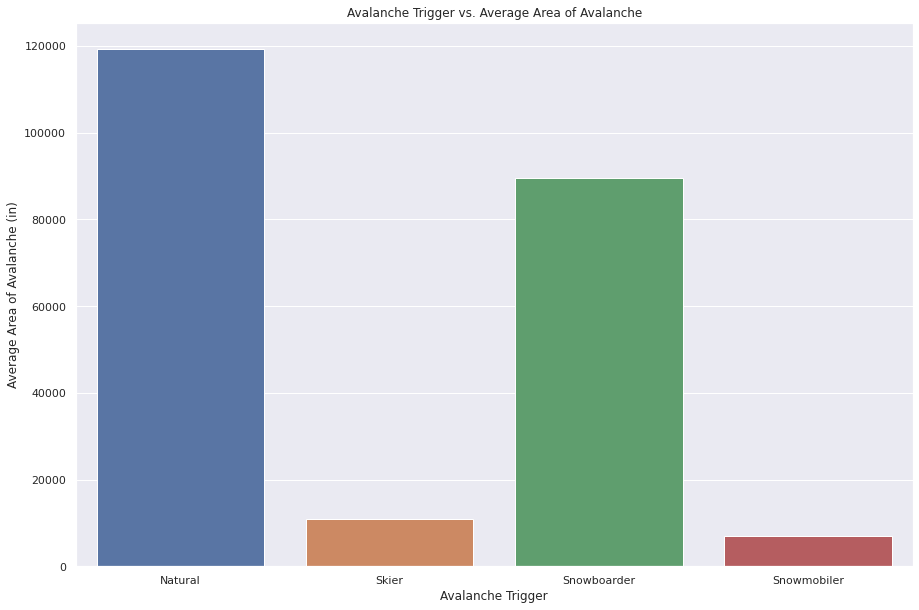

In [ ]:
import seaborn as sb

x = ['Natural', 'Skier', 'Snowboarder', 'Snowmobiler']
y = [float(natural_area_df.mean()), float(skier_area_df.mean()), float(snowmobiler_area_df.mean()), float(snowboarder_area_df.mean())]

sb.set(rc = {'figure.figsize':(15,10)})

ax = sb.barplot(x, y)
ax.set(xlabel= "Avalanche Trigger", ylabel = "Average Area of Avalanche (in)", title = "Avalanche Trigger vs. Average Area of Avalanche")


Now let's plot the data set with imputed values. We'll start off by calculating the mean like we did earlier.

In [ ]:
natural_area = []
skier_area = []
snowmobiler_area = []
snowboarder_area = []



for index in range(0, (len(replaced_av))):
  if replaced_av['Trigger'].iloc[index] == "Skier":
    skier_area.append(replaced_av['Area'].iloc[index])

  elif replaced_av['Trigger'].iloc[index] == "Natural":
    natural_area.append(replaced_av['Area'].iloc[index])

  elif replaced_av['Trigger'].iloc[index] == "Snowmobiler":
    snowmobiler_area.append(replaced_av['Area'].iloc[index])

  elif replaced_av['Trigger'].iloc[index] == "Snowboarder":
    snowboarder_area.append(replaced_av['Area'].iloc[index])

natural_area_df = pd.DataFrame(natural_area)
skier_area_df = pd.DataFrame(skier_area)
snowmobiler_area_df = pd.DataFrame(snowmobiler_area)
snowboarder_area_df = pd.DataFrame(snowboarder_area)


And we can now plot:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Average Area of Avalanche (in)'),
 Text(0.5, 0, 'Avalanche Trigger'),
 Text(0.5, 1.0, 'Avalanche Trigger vs. Average Area of Avalanche')]

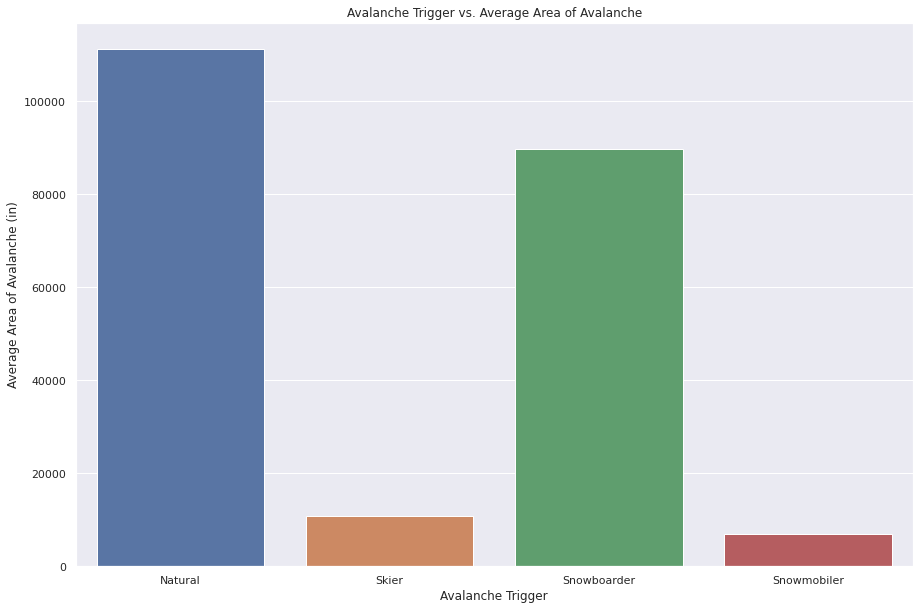

In [ ]:
y = [float(natural_area_df.mean()), float(skier_area_df.mean()), float(snowmobiler_area_df.mean()), float(snowboarder_area_df.mean())]
sb.set(rc = {'figure.figsize':(15,10)})

ax = sb.barplot(x, y)
ax.set(xlabel= "Avalanche Trigger", ylabel = "Average Area of Avalanche (in)", title = "Avalanche Trigger vs. Average Area of Avalanche")


The only difference between both graphs is that the average values appear to be smaller in the imputed graph. This is beacause we imputed the average values into the missing values, causing the graph to start approaching the average value more than the data set where we just dropped all values.

#Simple Solution

A simple solution to this problem would be determining the largest mean value of all four avalanche triggers. Whatever the largest mean is for all four triggers, that is the trigger that has the largest impact on area of an avalanche. The second highest mean has the second largest impact on the size of an avalanche. It goes so and and so fourth for the remaining triggers.

Based on both visualizations, we can see intitially that natural triggers on average have the highest area, followe by snowboarder, skier, and snowmobiler respectively.

However, let us see the exact numerical mean values before we make a conclusion from this simple test.

In [ ]:
print("Natural Area Average:")
print(float(natural_area_df.mean()))

print("Skier Area Average:")
print(float(skier_area_df.mean()))

print("Snowboarder Area Average:")
print(float(snowboarder_area_df.mean()))

print("Snowmobiler Area Average:")
print(float(snowmobiler_area_df.mean()))



Natural Area Average:
111301.997105644
Skier Area Average:
10727.229815054578
Snowboarder Area Average:
6889.52772073922
Snowmobiler Area Average:
89610.0


From just looking at the average areas of each type of avalanche trigger, it looks like natural triggers induce the largest area overall, with skiers coming second, snowmobilers coming in third, and snowboarders coming in last. As such, we can conclude from this simple test that **natural trigger avalanches are the most likely to have the largest areas.**

#Statisical Test

Let us dig further into our histogram. We can start off by using a four-way Analysis of Variance test to see how different our data truly is. An ANOVA tests allows us to see the largest difference in multiple sets of data

In [ ]:
from scipy.stats import f_oneway # anova
anova_score, p_value = f_oneway(natural_area, skier_area, snowmobiler_area, snowboarder_area)
print('ANOVA Score: {}'.format(anova_score))
print('P value: {}'.format(p_value))

ANOVA Score: 840.5158852363367
P value: 0.0


The P-value in this case is so low, that scipy is likely reporting back as zero. This means that the data is extremely statistically different. However, we have no idea which groups are truly different. We can only conclude from this test that two groups in the data are extremely different. A t-test would be possible here if we know which two groups they were, however just from this ANOVA test, we can't know which groups they are.

However, we know which two sets are the most different from our visualization. We can use the t-test to see how statisically significant they are. In this case, we will be doing the natural and snowmobiler data sets since those appear to be the most different.

In [ ]:
from scipy.stats import ttest_ind # t-test

t_score, p_value = ttest_ind(snowmobiler_area, natural_area)
print('T Score: {}'.format(t_score))
print('P value: {}'.format(p_value))

T Score: -5.636295130108657
P value: 1.8960728149493003e-08


The magnitude of the T-score is very large and negative, which tells us that the first sample mean of snowmobiler area is quite a bit smaller than the second sample of natural area mean. We also can see that the p value is very small and is much smaller than 0.01 or 0.05 and so our results are statistically significant.

In other words, avalanches caused by natural triggers are significantly larger in area than snowmobiler triggered ones.

I'm going to t-test natural triggers with the other two data sets to see how significant the largest average is compared to the other two sets.

In [ ]:
t_score, p_value = ttest_ind(skier_area, natural_area)
print('T Score: {}'.format(t_score))
print('P value: {}'.format(p_value))

T Score: -45.30717987487967
P value: 0.0


In [ ]:
t_score, p_value = ttest_ind(snowboarder_area, natural_area)
print('T Score: {}'.format(t_score))
print('P value: {}'.format(p_value))

T Score: -21.986958619175113
P value: 2.7883457935132218e-98


The magnitude of all of these t-scores are all really large and negative, and our p-values are extremely small, where one of them is so small that scipy gives of a zero value. **We can therefore conclude that natural triggers are significantly more likely on average to have the largest avalanche area compared to the other types of triggers.**

#Write up




> The purpose of this exploratory analysis was to determine if there is a relationship between avalanche triggers and the area of the avalanche. For example, is a ski-induced avalanche more likely to have the largest area on average? As such, the question that I decided to investigate was “Is there a relationship between certain types of avalanche triggers and the area of the avalanches caused by that trigger?” I chose this question because I wanted to determine if larger avalanches could be prevented if there was a certain type of trigger that was causing the largest avalanches on average, there can be potential application for prevention measures.

> My first step in this analysis was extracting the data from the Utah avalanche website. The data on this website is given by mountaineers , everyday skiers and climbers across the state. In other words, anyone can submit an avalanche incident to this data set on the website. This can present some issues, as non-qualified people are listing out depths and measurements about an avalanche. We can only trust that they are submitting accurate data. However, this data goes all the way back to 1914, and after scraping the website, I ended up coming up with around 6000 points of data, which is a very delightfully large sample size. My first step in extracting the data was to find a pattern in how the data was formatted across the website. I noticed that each row was nestled in between two <tr></tr> tags. As such, I used the find_all() function from the BeautifulSoup web scraping library. This created a data structure, where each index was just the contents of a <tr> tag. The next pattern I noticed within each <tr> tag was 6 different types of td tags. These were class tags that contained the occurrence date, the name of the avalanche, the region, the trigger, the depth, and the width. I did a for loop where I iterated through each <tr> tag in our array and pulled out all six of the columns and stored them into a variable. I then attached it to a JSON style payload and attached it to a dataframe. Using a for loop, I did this for all 122 pages (I kept increasing the number of the page which was shown at the end of the url at “page=” until it became undefined.) I converted it to a pandas data frame and was ready to start my analysis. I replaced any value that said  “unknown” or that was blank with an NaN value, which is derived from the numpy’s .nan function.  

>I employed two data cleaning methods. The first one was deletion. I simply deleted any nonexistent (NaN) values for trigger, depth or height. I lost 20% of my data through this process, which was not too bad of a loss in my opinion. The other cleaning method that I did was imputing the mean depth and width for each type of trigger. I did by finding the mean of each type trigger in the deleted data set. I found the mean by creating four separate data structures for each type of trigger, and used control flow to add values to its respective data structure based on its trigger. I then converted it to a pandas dataframe, and used the .mean() function to find it’s mean. I then separated the data set that still had the NaN values and rearranged it so that all types of triggers would be next to each other. I found the first index of the first type of trigger, and the last index for the last type of trigger, and I used slicing to create four separate pandas data structures. I called a fillna() and sent in the mean value for its respective trigger for each data structure. Then for both data structures, based on the inches or feet symbol at the end of each width or depth measurement, I converted it all to inches, removed the inches/feet symbol, removed any commas in large numbers,  and converted all values to float. I added a new column called area, which was derived by taking the width times the depth of that row. The data was now cleaned up.  I personally prefer to use the deleted data set when making my final conclusion, as adding values might skew my conclusion.

> I chose to do a bar chart for my visualization. This was because I was comparing four different values against each other; these values were discrete, so using a bar chart was my best bet in visually seeing their magnitude in terms of height. I set my x-axis to the four types of triggers, which made the x-axis discrete. My y-axis was set to the average area for each type of trigger.  In both the deleted and the imputed data set, the naturally triggered avalanche had the highest area on average, followed by snowboarders, skiers, and snowmobilers. To determine if the data was statistically significant, I used the ANOVA test. I ended up getting a p-value that was extremely close to zero, so I concluded that my conclusion was statistically significant. However, I wanted to take it a step further. Even though the ANOVA test could not tell me which data sets were statistically significant, my visualization did. I knew that the naturally triggered avalanches had the highest area on average. So I employed a t-test between the naturally triggered avalanches and the rest of the triggers. The t-values came back very large and negative, indicating that my conclusion was significant. I concluded that naturally induced avalanches on average are likely to have larger areas.

>One thing that I would like to improve on in my scraping process is time. It was very difficult to run the scraper each time and wait 5-10 minutes for the scraper to finish running. I would normally consider removing my sleep() function, however that would be unethical and damaging to the website servers. Additionally, the website continuously has more values added to it. While my code does handle all types of scraping, the data might become less accurate over time if more NaN values get added to the website. My scraper might also be scraping too fast, as one second gaps may be potentially overloading the servers of the website. However, I did not notice any issues in this regard, and I did not get rejected from scraping so I believe that I was scraping moderately and appropriately.

>The applications for this analysis are certainly significant. Avalanche specialists can work towards studying naturally caused avalanches as opposed to other types of avalanches in order to further predict, or if necessary, prevent them.




